In [105]:
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw
import numpy as np
from pathlib import Path
import random
import plotly.express as px
from scipy import ndimage
import math
from tqdm.auto import tqdm
import pandas as pd
from skimage.filters import difference_of_gaussians

In [2]:
import sys
sys.path.append('../../30_data_tools/')

from helper import load_dotenv

In [57]:
TILE_SIZE = 224

In [3]:
dotenv = load_dotenv()

In [4]:
tile_dataset = dotenv['TILE_DATASET_DIR'] / 'train'

In [5]:
moire_images = list( (tile_dataset / 'moire').glob('./*.jpg') )

In [6]:
def get_fft( input_img ):
    ft = np.fft.ifftshift(np.array(input_img)[:,:,0])
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    
    return ft

def invert_fft (input_real, input_imaginary):
    input = (input_real + 1j * input_imaginary)
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

In [7]:
def get_spherical_coordinate( x, y ):
    r = math.sqrt( x ** 2 + y ** 2 )
    angle = math.degrees(math.atan2(y,x))

    return r, angle

In [8]:
def limit_frequencies( fft, inner_limit=None, outer_limit=None ):
    center = (fft.shape[1] / 2, fft.shape[0] / 2)
    for y in range(fft.shape[0]):
        for x in range(fft.shape[1]):
            r = math.sqrt( abs(center[0] - x) ** 2 + abs(center[1] - y) ** 2 )
            
            if outer_limit is not None and r > outer_limit:
                fft[y,x] = 0
    
            if inner_limit is not None and r < inner_limit:
                fft[y,x] = 0

    return fft

In [114]:
def display_tiles( tiles, cols=5 ):
    row_count = math.ceil(len(tiles) / cols)
    
    out_img = Image.new(
        'RGB',
        (TILE_SIZE * cols, TILE_SIZE * row_count),
        color="white"
    )

    for i in range(len(tiles)):
        row = math.floor(i / cols)
        col = i % cols
        tile_img = Image.open(tiles[i][0])
        
        draw = ImageDraw.Draw(tile_img)  
        draw.rectangle(
            (
                ( 0, round(TILE_SIZE * 0.9) ),
                ( TILE_SIZE, TILE_SIZE )
            ),
            outline=None,
            fill='orange'
        )
        draw.text(
            ( round(TILE_SIZE * 0.5), round(TILE_SIZE * 0.97) ),
            str(tiles[i][1].round()),
            anchor='ms',
            font_size=15
        )
        
        out_img.paste(
            tile_img,
            (col * TILE_SIZE, row * TILE_SIZE)
        )

    return out_img

In [9]:
moire_path = random.choices(moire_images, k=1)[0]

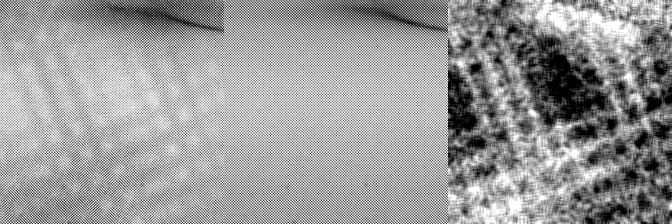

In [23]:
display_image = Image.new(size=(moire_img.size[0]*3, moire_img.size[1]), mode='L')
display_image.paste(moire_img, (0,0))
display_image.paste(no_moire_img, (moire_img.size[0],0))
display_image.paste(diff_img, (moire_img.size[0]*2,0))

display_image

In [94]:
rows = []
selection = random.choices(moire_images, k=1000)

for moire_path in tqdm(selection):
    non_moire_path = tile_dataset / 'no_moire' / moire_path.name
    
    moire_img = Image.open( moire_path )
    no_moire_img = Image.open( non_moire_path )
    
    diff_img = Image.fromarray(np.array(moire_img) - np.array(no_moire_img))
    diff_img = diff_img.filter(ImageFilter.BoxBlur(2))
    enhancer = ImageEnhance.Contrast(diff_img)
    diff_img = enhancer.enhance(2)
    
    
    fft = get_fft(
        diff_img.resize((
            round(diff_img.size[0] / 2),
            round(diff_img.size[1] / 2)
        ))
    )
    fft = limit_frequencies( fft, inner_limit=5, outer_limit=140 )
    fft = np.abs( fft )
    fft = ndimage.gaussian_filter(fft, sigma=3)
    
    data = []
    for y in range(fft.shape[0]):
        for x in range(fft.shape[1]):
            r, angle = get_spherical_coordinate( x - round(fft.shape[1] / 2), y - round(fft.shape[0] / 2) )
            data.append((
                r,
                angle,
                fft[y,x]
            ))
    #rows.append(np.array([val[2] for val in sorted(data, key=lambda val: (val[0], val[1]))]))
    rows.append(fft.real.flatten())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
from sklearn.cluster import KMeans

In [95]:
X = np.array(rows)

# PCA

In [154]:
from sklearn.decomposition import PCA

In [156]:
pca = PCA()
pca.fit(X)

PCA()

In [164]:
X_pca = pca.transform(X)

In [159]:
pca.explained_variance_ratio_.shape

(1000,)

In [161]:
pca.singular_values_.shape

(1000,)

In [153]:
X.shape

(1000, 12544)

# Clustering mit ResNet

In [133]:
import torch
from torchvision import models, transforms

In [185]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(2048, 2048)

for param in model.parameters():
    param.requires_grad = False

In [200]:
rows = []
selection = random.choices(moire_images, k=500)

for moire_path in tqdm(selection):
    non_moire_path = tile_dataset / 'no_moire' / moire_path.name
    
    moire_img = Image.open( moire_path )
    no_moire_img = Image.open( non_moire_path )
    
    diff_img = Image.fromarray(np.array(moire_img) - np.array(no_moire_img))
    diff_img = diff_img.filter(ImageFilter.BoxBlur(2))
    enhancer = ImageEnhance.Contrast(diff_img)
    diff_img = enhancer.enhance(2)

    transform = transforms.Compose([transforms.PILToTensor()])
    
    tensor = transform(diff_img) / 255
    tensor = tensor.reshape((1,3,224,224))
    rows.append( model(tensor)[0].numpy() )

  0%|          | 0/500 [00:00<?, ?it/s]

In [201]:
X = np.array(rows)

# silhouette Analyse

In [86]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [204]:
for n_clusters in range(2,10):

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.04971934
For n_clusters = 3 The average silhouette_score is : 0.04788363
For n_clusters = 4 The average silhouette_score is : 0.034315787
For n_clusters = 5 The average silhouette_score is : 0.033527166
For n_clusters = 6 The average silhouette_score is : 0.028050624
For n_clusters = 7 The average silhouette_score is : 0.02649184
For n_clusters = 8 The average silhouette_score is : -0.0044454285
For n_clusters = 9 The average silhouette_score is : -0.0041893143


In [206]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X)

In [208]:
prediction = kmeans.predict(X)

for i in range(prediction.max() + 1):
    relevant_images = []
    
    for j in range(len(selection)):        
        if prediction[j] == i:
            relevant_images.append((
                selection[j],
                np.linalg.norm(
                    kmeans.cluster_centers_[prediction[j]] - X[j]
                )
            ))
    
    display_tiles( sorted(relevant_images, key=lambda val: val[1]) ).save(f'/Users/frederic.birwe/Downloads/tiles_{ i }.jpg')